In [256]:
# imports and configs

from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import world_bank_data as wb

# make plots a bit bigger
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
print(pd.options.display.max_rows)
print(pd.options.display.expand_frame_repr)
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

20
False


In [257]:
# --------------------------------------------------
# load the datasets


df_c = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_r = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

# --------------------------------------------------
# next rotate them to add a Date column

ids = ['Country/Region', 'Province/State', 'Lat', 'Long']
numericalbase = ['Confirmed', 'Deaths', 'Recovered']

df_c = df_c.melt(id_vars=ids, var_name="Date", value_name="Confirmed")
df_d = df_d.melt(id_vars=ids, var_name="Date", value_name="Deaths")
df_r = df_r.melt(id_vars=ids, var_name="Date", value_name="Recovered")

# --------------------------------------------------
# next merge the Confirmed/Deaths/Recovered into one dataframe

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
keys = ids + ["Date"]

df = pd.merge(df_c, df_d, how='outer', on=keys)
df = pd.merge(df, df_r, how='outer', on=keys)
df = df.reset_index()

# --------------------------------------------------

for n in numericalbase:
    df[n] = df[n].fillna(0)

# --------------------------------------------------
# ad an active column

df['Active'] = df['Confirmed'] - (df['Recovered'] + df['Deaths'])

numericalbase.append('Active')

# --------------------------------------------------
# some countries have no Province/State, we need empty strings

df['Province/State'] = df['Province/State'].fillna('-')

# --------------------------------------------------
# finally cleanup the dates (who uses M/D/Y in a dataset ???)

#print(df)
#for d in df['Date']:
#    print(d)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# --------------------------------------------------
# add an Id column

df['Id'] = df['Country/Region'] + '-' + df['Province/State']

# --------------------------------------------------
# add Increase columns

numericalcolors = { 'Confirmed':'blue',
                    'Deaths':   'red',
                    'Recovered':'green',
                    'Active':   'orange' }

numerical = []
gb = df.groupby('Id')
for n in numericalbase:
    numerical.append(n)
        
    ni = '%sIncrease' % n
    df[ni] = gb[n].diff()
    numerical.append(ni)
    
    #na = '%sAvg' % n
    #df[na] = gb[n].apply(pd.rolling_mean, 3, min_periods=1)
    #df[na] = gb[n].transform('cumsum')
    #numericalx.append(na)
    
# --------------------------------------------------
# these are the columns we may want to sum later

aggregation = {}
for n in numerical:
    aggregation[n] = 'sum'

# --------------------------------------------------
# fix column order

cols = ['Id'] + keys + numerical

df = df[cols]

# --------------------------------------------------
# sort by Confirmed column

#df = df.sort_values(by=['Date', 'Confirmed'])

# --------------------------------------------------
# write it for review

df.to_csv("csse-combined.csv", index=False)

# --------------------------------------------------
# dump

#for c in df.columns:
#    u = df[c].unique()
#    print("%-20s %u" % (c, len(u)))

#print(df['Country/Region'].unique())

df = df.fillna(0)
#df.describe(include="all")
#df.isna().sum()
x = df[df['Country/Region'] == 'US']
print(x[x['Date'] == datetime(2020,3,30)])
print("--")
print(x[x['Date'] == datetime(2020,3,31)])


         Id Country/Region Province/State      Lat     Long       Date  Confirmed  ConfirmedIncrease  Deaths  DeathsIncrease  Recovered  RecoveredIncrease    Active  ActiveIncrease
18041  US--             US              -  37.0902 -95.7129 2020-03-30   161807.0            20921.0  2978.0           511.0     5644.0             2979.0  153185.0         17431.0
--
         Id Country/Region Province/State      Lat     Long       Date  Confirmed  ConfirmedIncrease  Deaths  DeathsIncrease  Recovered  RecoveredIncrease    Active  ActiveIncrease
18303  US--             US              -  37.0902 -95.7129 2020-03-31   188172.0            26365.0  3873.0           895.0     7024.0             1380.0  177275.0         24090.0


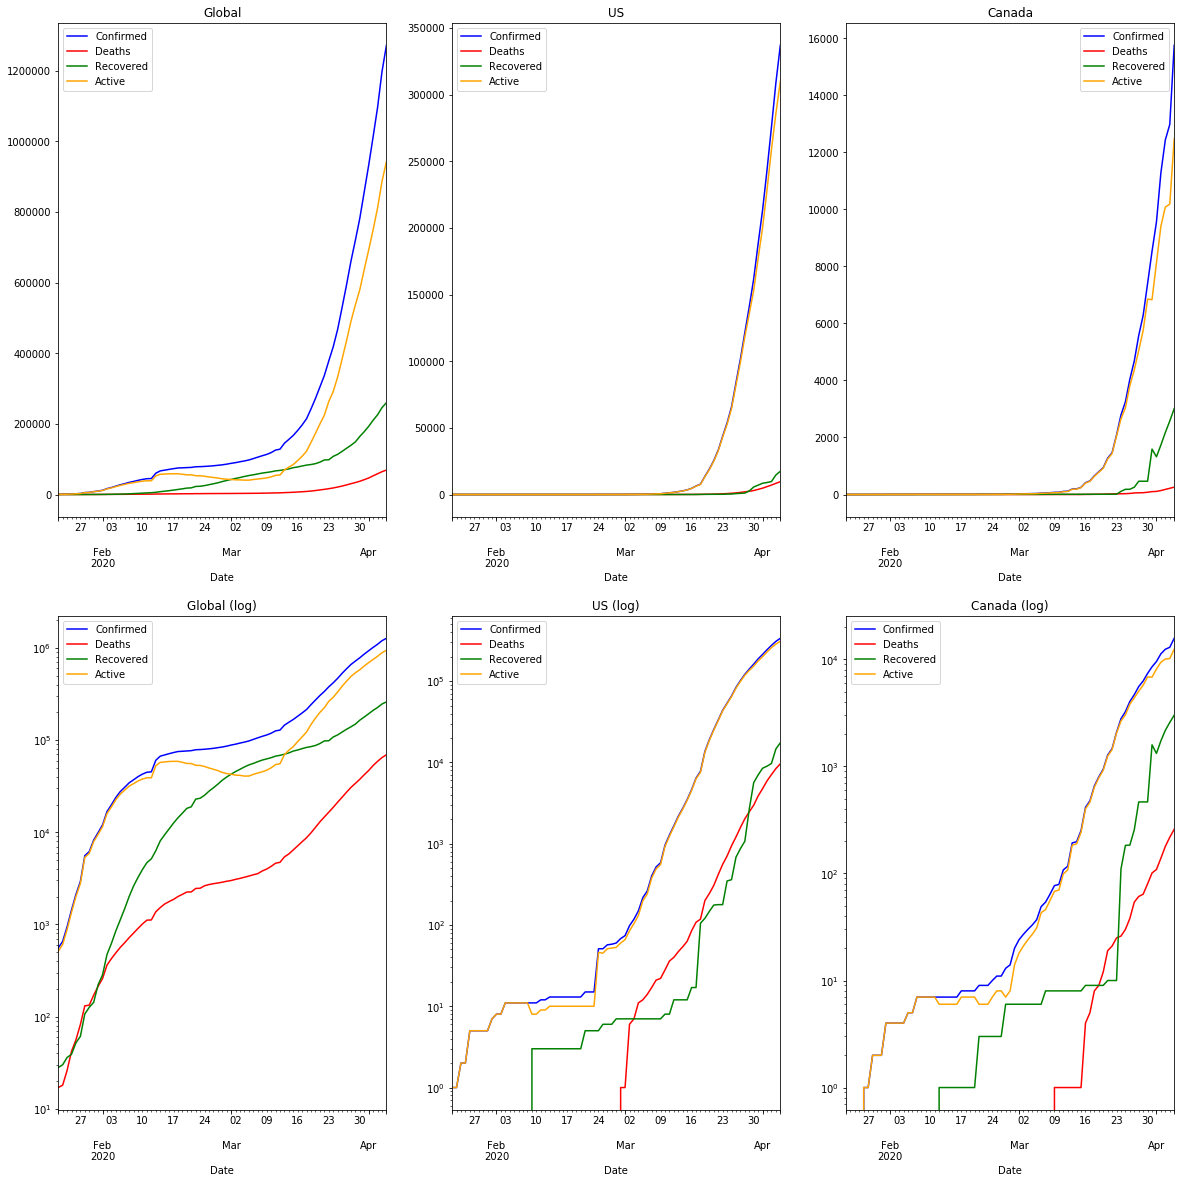

In [258]:
gbl = df.groupby(['Date'],as_index=False).agg(aggregation)

cdn = df.loc[df['Country/Region'] == 'Canada']
cdn = cdn.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

usa = df.loc[df['Country/Region'] == 'US']
usa = usa.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

DATA = [{'n':'Global', 'df':gbl},
        {'n':'US',     'df':usa},
        {'n':'Canada', 'df':cdn}]

fig, axs = plt.subplots(2, len(DATA))

i=0
for d in DATA:
    p = d['df']
    
    #print(d['n'])
    #print(p)
    
    ax = axs[0][i]
    ax.set_title(d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    i = i+1

plt.show()


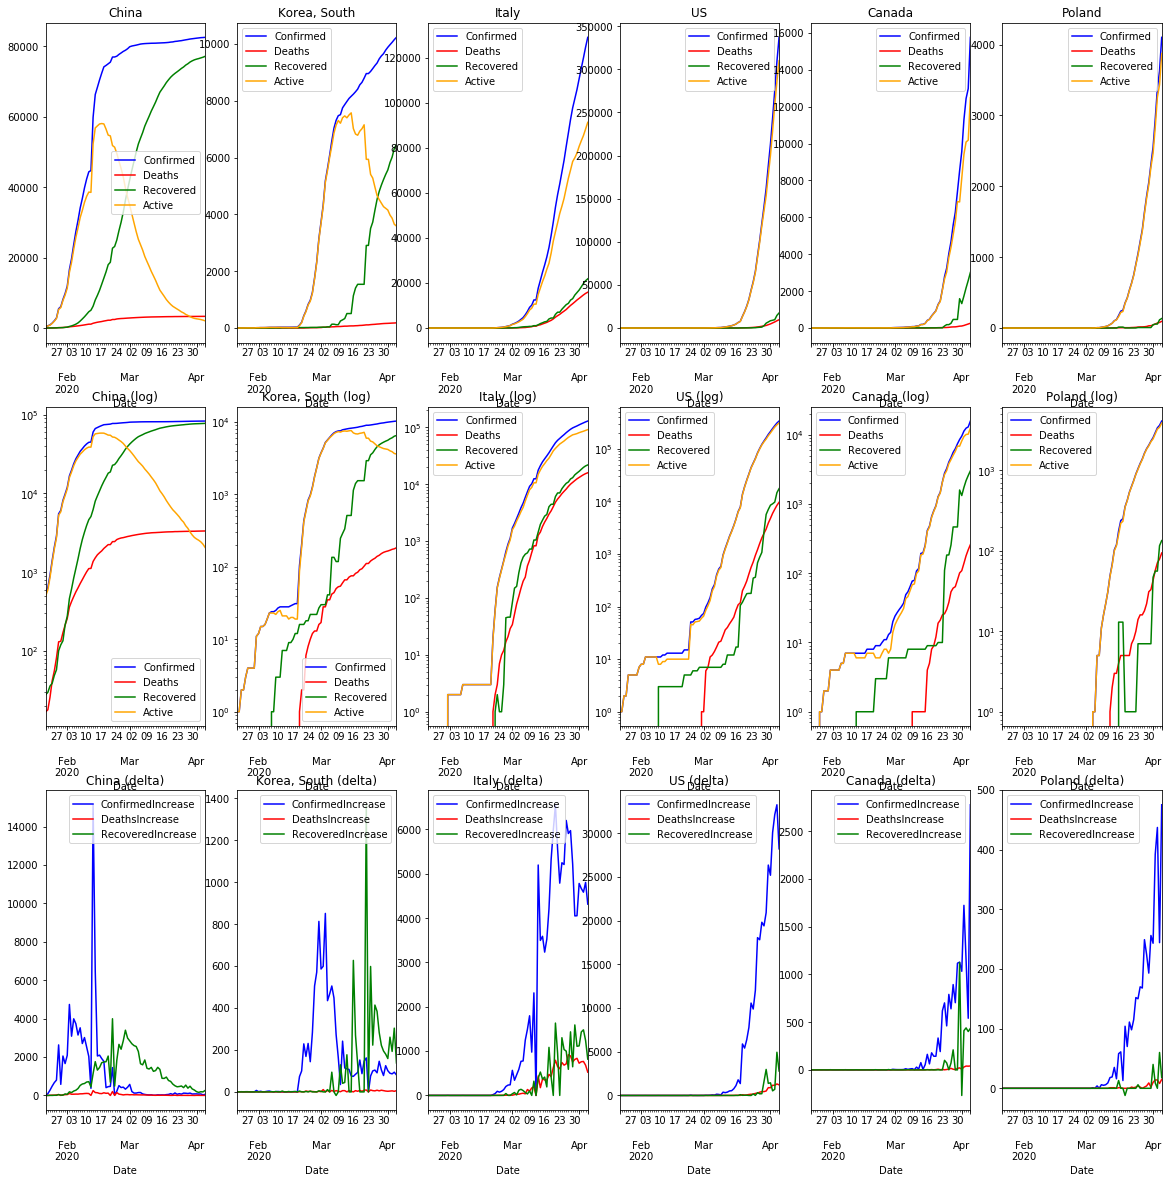

In [259]:
#print(df['Country/Region'].unique())
countries = ['China', 'Korea, South', 'Italy', 'US', 'Canada', 'Poland']

fig, axs = plt.subplots(3, len(countries))

i = 0
for country in countries:
    p = df.loc[df['Country/Region'] == country]
    p = p.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

    ax = axs[0][i]
    ax.set_title(country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)


    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[2][i]
    ax.set_title("%s (delta)" % country)
    for col in numericalbase:
        if col == "Active":
            continue
        p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

    i = i + 1

fig.savefig('out/countries.png')
plt.show()


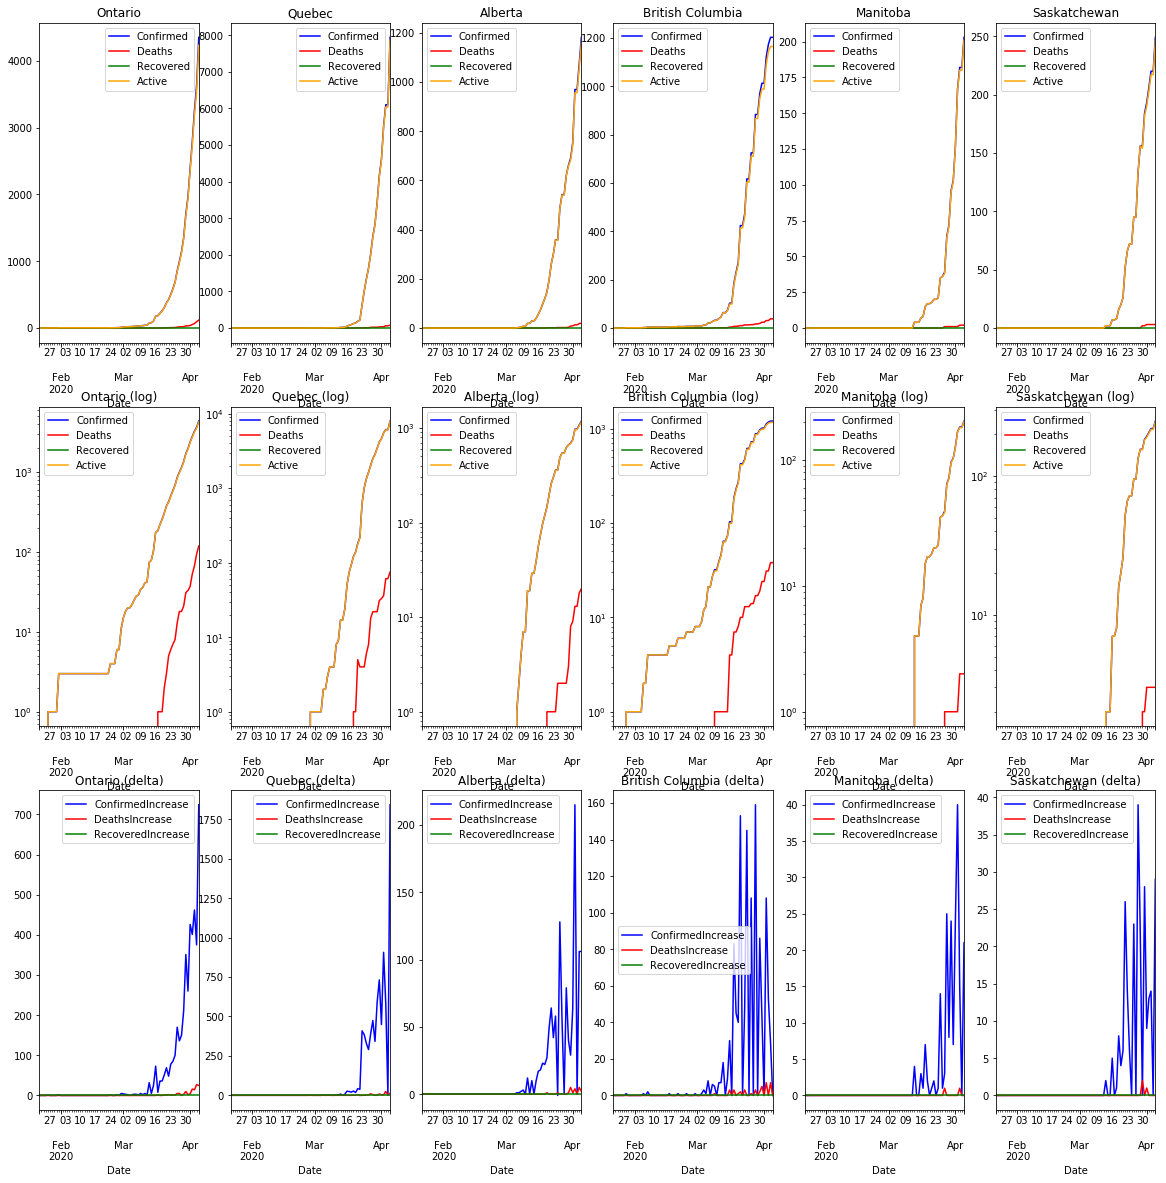

In [260]:
country = 'Canada'
cdf = df.loc[df['Country/Region'] == country]

#regions = cdf['Province/State'].unique()
#regions = regions[0:8]
#print(regions)

regions = ['Ontario', 'Quebec', 'Alberta', 'British Columbia', 'Manitoba', 'Saskatchewan']


fig, axs = plt.subplots(3, len(regions))

i = 0
for region in regions:
    d = cdf.loc[df['Province/State'] == region]

    p = d.groupby(['Province/State','Date'],as_index=False).agg(aggregation)

    #print(p)
    try:
        ax = axs[0][i]
        ax.set_title(region)
        for col in numericalbase:
            p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

        ax = axs[1][i]
        ax.set_yscale('log')
        ax.set_title("%s (log)" % region)
        for col in numericalbase:
            p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

        ax = axs[2][i]
        ax.set_title("%s (delta)" % region)
        for col in numericalbase:
            if col == "Active":
                continue
            p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

        i = i + 1

    except Exception as err:
        pass


fig.savefig('out/canada.png')
plt.show()


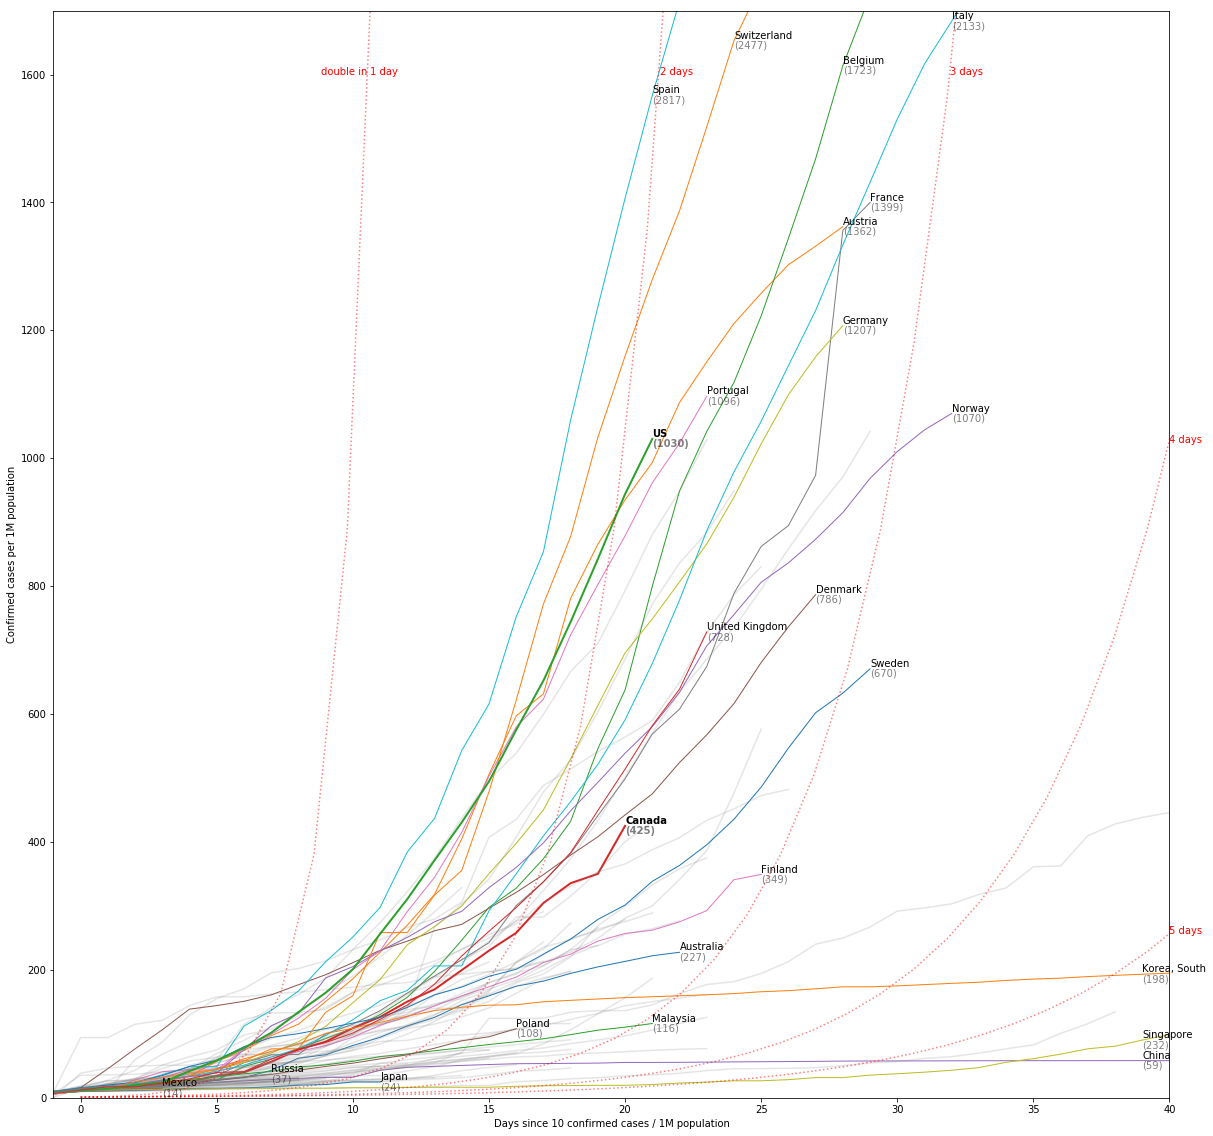

In [261]:
# we will get the population of each country from this data set...
pop = wb.get_series('SP.POP.TOTL', mrv=1).reset_index()
#print(pop['Country'].unique())
# some countries in the pop database have different names
popnames = {'US':'United States',
           'Korea, South':'Korea, Rep.',
           'Russia':'Russian Federation'}

# configuration
showDoublingAtY = 1600
logScale = False
startCountingAfter = 10
startCountingAfter1M = True
nameUnfocusedCountries = False

# countries we want to show in colour...
focus = ['Canada','US','China','Korea, South','United Kingdom','Poland','Mexico','Italy','Spain','France','Germany','Russia','Japan','Belgium','Norway','Austria','Australia','Sweden','Denmark','Singapore','Malaysia','Switzerland','Finland','Portugal']
#focus = ['Canada','US']

# aggregate data...
pc = ['Country/Region', 'Province/State', 'Date', 'Confirmed', 'ConfirmedIncrease', 'Deaths', 'DeathsIncrease', 'Recovered', 'RecoveredIncrease', 'Active', 'ActiveIncrease']
d = df[pc]
d = d.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

# these are all the countries...
countries = d['Country/Region'].unique()

# helper
def label_location(c):
    end = c.tail(1)
    x = int(end['Since'])
    y = float(end['ConfPer1M'])
    #print("%-20s - %u, %f" % (cn,ex,ey))
    if x <= xlim[1] and y <= ylim[1]:
        return (x, y, y)
    end = c[ (c['Since'] < xlim[1]) & (c['ConfPer1M'] < ylim[1]) ].tail(1)
    ex = int(end['Since'])
    ey = float(end['ConfPer1M'])
    return (ex, ey, y)


# create a plot...
fig, ax = plt.subplots(1,1)

if logScale:
    xlim = None
    ylim = [0.1,2000]
    ax.set_yscale('log')
    showDoublingAtY = False
else:
    xlim=[-1,40]
    ylim=[0,1700]

# start plotting...
for cn in countries:
    # figure out how many people live in the country
    pn = cn
    if cn in popnames.keys():
        pn = popnames[cn]
    
    num = 0
    try:
        num = int(pop[pop['Country'] == pn]['SP.POP.TOTL'])
    except Exception as err:
        if cn in focus:
            print(cn,err)
        pass
    
    # skip countries with low populations
    if num < 1000000:
        continue
            
    try:
        c = d[d['Country/Region'] == cn].copy()
        c['ConfPer1M'] = c['Confirmed'] * 1000000 / num
        
        if startCountingAfter1M:
            idx = c[c['ConfPer1M'].ge(startCountingAfter)].index[0]
        else:
            idx = c[c['Confirmed'].ge(startCountingAfter)].index[0]
            
        s = c.loc[idx]['Date']
        c['Since'] = c['Date'] - s
        c['Since'] = c['Since']/np.timedelta64(1,'D')
        c = c[c['Since'] > -10]
        
        

        if cn in focus:
            linewidth=1
            textweight='normal'
            if cn in ['Canada','US']:
                linewidth=2
                textweight='bold'
                
            c.plot(kind='line',x='Since',y='ConfPer1M', label=cn, linewidth=linewidth, legend=logScale, ax=ax)
            
            (ex,ey,v) = label_location(c)
            ax.text(ex, ey, cn, va='bottom', fontweight=textweight)
            ax.text(ex, ey, "(%u)"%v, va='top', fontweight=textweight, alpha=0.5)
                
            
        else:
            c.plot(kind='line',x='Since',y='ConfPer1M', legend=False, color='gray', alpha=0.2, ax=ax)

            if nameUnfocusedCountries:
                (ex,ey,v) = label_location(c)
                ax.text(ex, ey, cn, alpha=0.2)
            
    except Exception as err:
        #print(cn,err)
        pass

if showDoublingAtY:
    def double_daily(base, arr):
        arr = np.asarray(arr)
        result = np.power(base,arr)
        return result
    for doublein in [1,2,3,4,5]:
        base = np.power(2,1/doublein)
        x = np.linspace(0,60)
        y = double_daily(base,x)
        plt.plot(x,y,color='red',alpha=0.5,linestyle=':')
        y = showDoublingAtY
        x = math.log(y, base)
        s = "%u day%s" % (doublein, "s" if doublein>1 else "")
        if x > xlim[1]:
            x = xlim[1]
            y = np.power(base,x)
        plt.text(x, y, s, color='red')
        if doublein == 1:
            plt.text(x, y, "double in ", color='red', ha='right')

if startCountingAfter1M:
    ax.set_xlabel("Days since %u confirmed cases / 1M population" % startCountingAfter)
else:
    ax.set_xlabel("Days since %u confirmed cases" % startCountingAfter)
ax.set_ylabel("Confirmed cases per 1M population")

if logScale:
    ax.set_ylim(ylim)
else:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.savefig('out/country-tends.png')
plt.show()